# Kognitive Systeme - Lab 2

In dieser Laborübung geht es darum, das Prinzip des Q-Learnings an Hand eines praktischen Beispiels zu vertiefen. Als Grundlage dafür dient das Taxi-Problem aus OpenAI (https://gym.openai.com/). Das fertig erstellte, dokumentierte und lauffähige Notebook schicken Sie bis Donnerstag, 26.11.2020 (23:59:59 MEZ) an norbert.oswald@unibw.de

Ein autonom fahrendes Taxi sammelt einen Passagier an einem Startort ein
und fährt ihn zu seinem Zielort. Dafür sind folgende Aktivitäten erforderlich:
* Identifikation des Startortes, die Fahrt dorthin sowie das Einladen des Passagiers
* Identifikation des Zielortes, die Fahrt dorthin sowie das Ausladen des Passagiers

Beide Aktivitäten sollen schnellstmöglich durchgeführt werden. Die Simulationsumgebung liefert folgende Informationen:

* 25 mögliche Positionen für das Taxi
* ein Taxi ohne Passagier ist gelb/rot, sonst grün
* 4 mögliche fixe Start- oder Zielorte R,G,B oder Y
* konkreter Startort ist blau, Zielort ist pink
* 5 Positionen, an denen sich ein Passagier befinden kann

Für den Taxi-Agenten sollen 3 verschiedene Verhaltensweisen realisiert werden. In der ersten Aufgabe agiert der Taxi-Agent rein zufällig, in der zweiten Aufgabe basieren seine Entscheidungen auf dem Prinzip des Q-Learning und in der dritten Aufgabe verwendet der Agent das SARSA Lernverfahren. Für alle drei Aufgabe sind kleine Sourcecode-Fragemente vorgegeben. Ergänzen Sie diese an den angegebenen Stellen mit Ihrer Implementierung und überprüfen Sie das gewünschte Verhalten. Dokumentieren Sie für alle 3 Verfahren jeweils Ihre Vorgehensweise. 

In [1]:
import gym

# env = gym.make('Taxi-v3')
env = gym.make('Taxi-v3').env

## Aufgabe 1

Schreiben Sie eine Python-Anwendung für einen Taxiagenten, der seine Aktionen zufällig auswählt. Geben Sie an, welche Belohnung Sie erhalten und nach wievielen Schritten eine Lösung gefunden wurde.

In [2]:
def execute():
    print ("Ausführungsphase")
    #
    # An dieser Stelle soll Ihre Implementierung des 
    # zufällig agierenden Taxiagenten stehen  
    #

    env.reset()

    done = False    
    steps = 0
    score = 0

    while not done:

        # https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py

        # OBSERVATIONS:
        # 500 discrete states 
        # 25 taxi positions
        # 5 possible locations
        # 4 destination locations

        # ACTIONS:
        # move 0=south, 1=north, 2=east, 3=west, 4=pickup, 5=dropOff
  
        # choose random action
        action = env.action_space.sample()               
        # execute selected action
        _, reward, done, _ = env.step(action)

        steps += 1 
        score += reward

    print (f"steps: {steps}, score: {score}")

Testen Sie das Verhalten Ihrer Implementierung, indem Sie die nachfolgende Zelle ausführen. Mit *env.render()* wird der aktuelle Zustand visualisiert.

In [3]:
execute()
env.render()

Ausführungsphase
steps: 2148, score: -8328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


## Aufgabe 2

Das Verhalten des Taxi-Agenten soll nun so geändert werden, dass die von ihm vorgeschlagenenen Aktionen gemäß dem Q-Learning Algorithmus ermittelt wurden. 

Um Q-Learning anwenden zu können ist zunächst eine Lernphase notwendig. Ergänzen Sie zu diesem Zweck die nachfolgende Methode *learn()* in geeigneter Art und Weise. Die Übergabeparameter dürfen bei Bedarf angepasst werden.

In [4]:
import numpy
import random
import matplotlib.pyplot

def learn(episodes: int = 20000):
    print ("Lernphase mit Q-Learning")
    #
    # An dieser Stelle soll Ihre Implementierung des 
    # Lernvorgangs für Q-Learning stehen  
    #

    # https://casey-barr.github.io/open-ai-taxi-problem/

    ###
    # CREATE Q-TABLE

    max_observations =  env.observation_space.n
    max_actions =  env.action_space.n

    print("max_observations:", max_observations)
    print("max_actions:", max_actions)

    q_table = numpy.zeros((max_observations, max_actions))

    print("q-table_shape:", q_table.shape)

    ###
    # HYPERPARAMETER

    alpha = 0.05    # learning rate
    gamma = 0.9     # weighting factor

    ###
    # EXPLORATION

    # script v08-a s.29
    epsilon = 0.3           # exploration (or greedy)
    epsilon_min = 0.03      # min exploration
    epsilon_faktor = 0.5    # exploration faktor

    ###
    # START Q-LEARNING

    steps_list = list()
    score_list = list()

    for episode in range(episodes):
        
        state = env.reset()

        done = False
        steps = 0
        score = 0

        while not done:
            
            ###
            # EXPLORATION OR GREED

            # choose argmax action with propabilty 1-epsilon
            # otherwise choose random action
            if random.uniform(0, 1) > epsilon:
                action = numpy.argmax(q_table[state])
            else:
                action = env.action_space.sample()

            # execute selected action
            next_state, reward, done, _ = env.step(action)

            steps += 1
            score += reward

            ###
            # Q-LEARNING

            # script v08-a s.22
            old_value = q_table[state, action]
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * numpy.max(q_table[next_state]))
            # replace old_value
            q_table[state, action] = new_value

            state = next_state#

        # reduce epsilon (exploration) which leads to an increase in greed
        if (epsilon > epsilon_min):
            epsilon *= epsilon_faktor

        ###
        # DEBUG INFORMATION
        
        steps_list.append(steps)
        score_list.append(score)
    
        if(episode % 1000 == 0):
            print (f"episode: {episode}, steps: {steps}, score: {score}")
        
    matplotlib.pyplot.plot(steps_list, ".", label="steps") 
    matplotlib.pyplot.plot(score_list, ".", label="score")
    matplotlib.pyplot.show()

    return q_table

Damit der Taxi-Agent von dem gelernten profitieren kann, ist eine entsprechende Ausführungsmethode zu programmieren. Ergänzen Sie zu diesem Zweck die nachfolgende Methode *execute()*. Die Übergabeparameter dürfen bei Bedarf angepasst werden. 

In [5]:
def execute(q_table):
    print ("Ausführungsphase mit Q-Learning")
    #
    # An dieser Stelle soll Ihre Implementierung der 
    # Aktionsausführung des Taxi-Agenten gemäß Q-Learning stehen  
    # 

    state = env.reset()

    done = False
    steps = 0
    score = 0

    while not done:

        # choose best action
        action = numpy.argmax(q_table[state])
        # execute selected action
        next_state, reward, done, _ = env.step(action)

        steps += 1
        score += reward
        
        state = next_state    

        # render environment
        env.render()

    print (f"steps: {steps}, score: {score}")

Testen Sie das Verhalten Ihrer Implementierung, indem Sie z.B. die nachfolgende Zelle ausführen. Geben Sie an, welche Belohnung Sie erhalten und nach wievielen Schritten eine Lösung gefunden wurde.

Lernphase mit Q-Learning
max_observations: 500
max_actions: 6
q-table_shape: (500, 6)
episode: 0, steps: 797, score: -2171
episode: 1000, steps: 35, score: -14
episode: 2000, steps: 9, score: 12
episode: 3000, steps: 15, score: 6
episode: 4000, steps: 7, score: 14
episode: 5000, steps: 17, score: 4
episode: 6000, steps: 14, score: 7
episode: 7000, steps: 12, score: 9
episode: 8000, steps: 18, score: -6
episode: 9000, steps: 18, score: 3
episode: 10000, steps: 14, score: 7
episode: 11000, steps: 11, score: 10
episode: 12000, steps: 7, score: 14
episode: 13000, steps: 9, score: 12
episode: 14000, steps: 13, score: 8
episode: 15000, steps: 9, score: 3
episode: 16000, steps: 15, score: 6
episode: 17000, steps: 14, score: 7
episode: 18000, steps: 16, score: -4
episode: 19000, steps: 15, score: 6


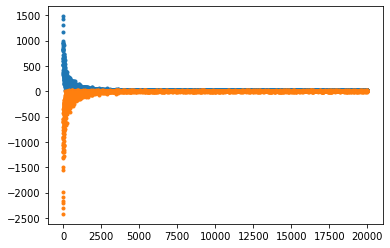

Ausführungsphase mit Q-Learning
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | :

In [6]:
q_table = learn()
execute(q_table)

## Aufgabe 3

Nun soll das Verhalten des Taxi-Agenten mit dem SARSA Algorithmus implementiert werden. Vergleichen und Interpretieren Sie die Ergebnisse, die Sie mit Q-Learning und mit SARSA erhalten.


In [7]:
def learn():
    print ("Lernphase mit SARSA")
    #
    # An dieser Stelle soll Ihre Implementierung des 
    # Lernvorgangs für SARSA stehen  
    # 

In [8]:
def execute():
    print ("Ausführungsphase mit SARSA")
    #
    # An dieser Stelle soll Ihre Implementierung der 
    # Aktionsausführung des Taxi-Agenten gemäß SARSA stehen  
    # 

In [9]:
learn()
execute()

Lernphase mit SARSA
Ausführungsphase mit SARSA
